In [1]:
import zipfile
import pandas as pd
import os

# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection
import seaborn as sns


# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from scipy.stats import zscore

In [2]:
# Load data
with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

# Divide data into test and train
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

Check number of sick and not sick

In [3]:
# number of sick and not sick
count = 0
for label in labels:
    if label == 0:
        count += 1

print(count)
print(len(labels))

681
827


In [4]:
# Calculate the Z-scores for each feature
z_scores = np.abs(zscore(X_train.iloc[:, 0:50]))

# Identify outliers (Z > 3 for each feature)
outliers = (z_scores > 3)

# Count the number of outliers for each feature
outliers_count = np.sum(outliers, axis=0)
print(f"Number of outliers per feature: {outliers_count}")

Number of outliers per feature: [14 13  9  9  8 12  8  8 17  7  5 16  8 14  5  6 14  8  3  9  2  3  9  3
  4  3  3  3  6 10  5  4  8  2  3  3  2  7  3  4  1  4  5  2  3  2  7  9
  7 10]


Check for zero values in dataset

In [5]:
# Check if there are any zero values in the entire DataFrame
zero_values = (x == 0)
print("Zero values present in the DataFrame:\n", zero_values)

# Count the number of zero values
num_zero_values = zero_values.sum().sum()
print(f"Total number of zero values: {num_zero_values}")

Zero values present in the DataFrame:
        0_0    0_1    0_2    0_3    0_4    0_5    0_6    0_7    0_8    0_9  \
0    False  False  False  False  False  False  False  False  False  False   
1    False  False  False  False  False  False  False  False  False  False   
2    False  False  False  False  False  False  False  False  False  False   
3    False  False  False  False  False  False  False  False  False  False   
4    False  False  False  False  False  False  False  False  False  False   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
822  False  False  False  False  False  False  False  False  False  False   
823  False  False  False  False  False  False  False  False  False  False   
824  False  False  False  False  False  False  False  False  False  False   
825  False  False  False  False  False  False  False  False  False  False   
826  False  False  False  False  False  False  False  False  False  False   

     ...  11_740  11_741  11_742  11

Check outliers after powertransformation

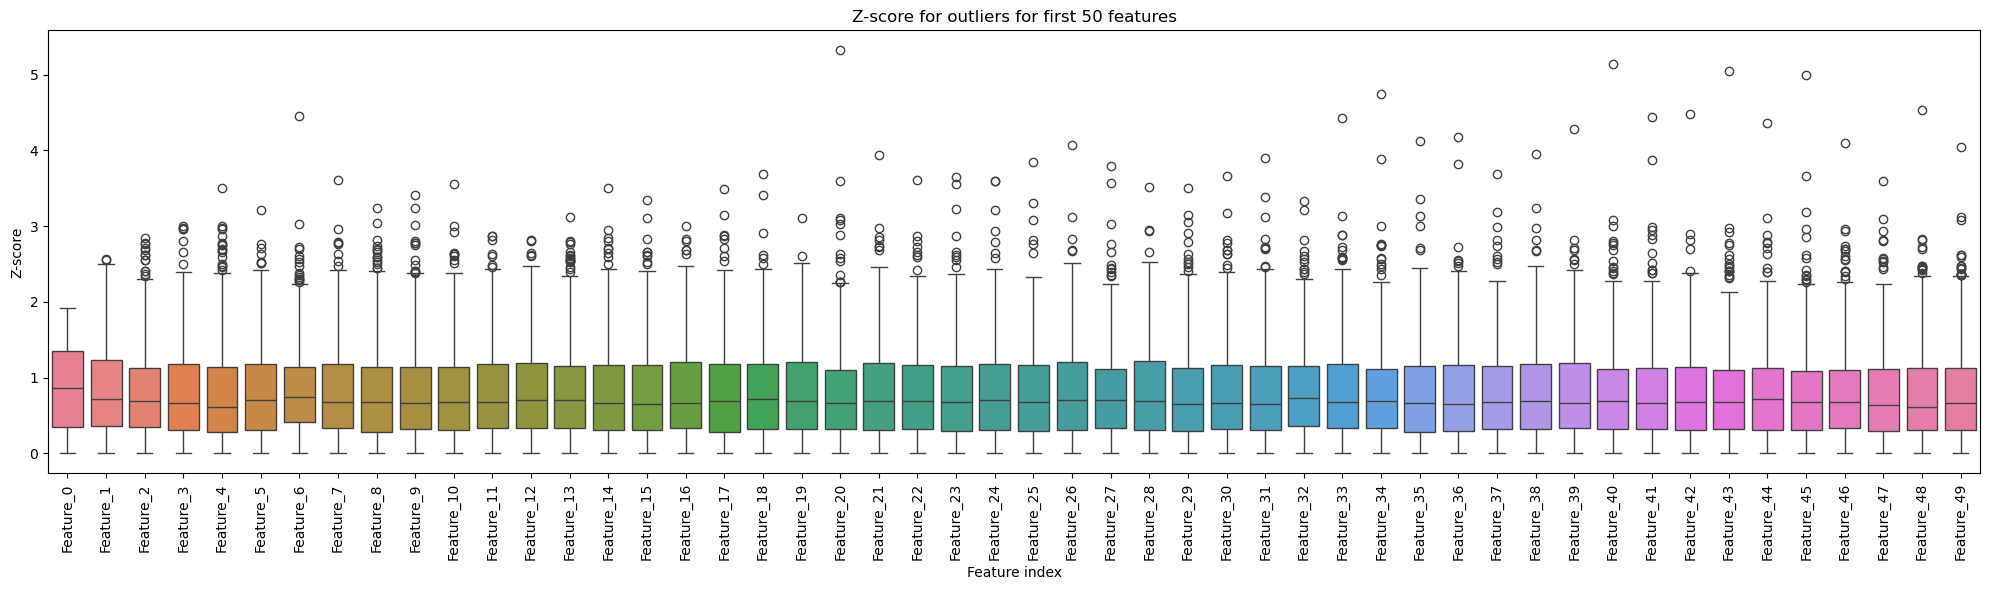

In [10]:
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

X_subset = X_train_transformed[:, :50]
z_scores = np.abs(zscore(X_subset))

z_df = pd.DataFrame(z_scores, columns=[f'Feature_{i}' for i in range(X_subset.shape[1])])

plt.figure(figsize=(20, 6))
sns.boxplot(data=z_df)
plt.title("Z-score for outliers for first 50 features")
plt.xlabel("Feature index")
plt.ylabel("Z-score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Features

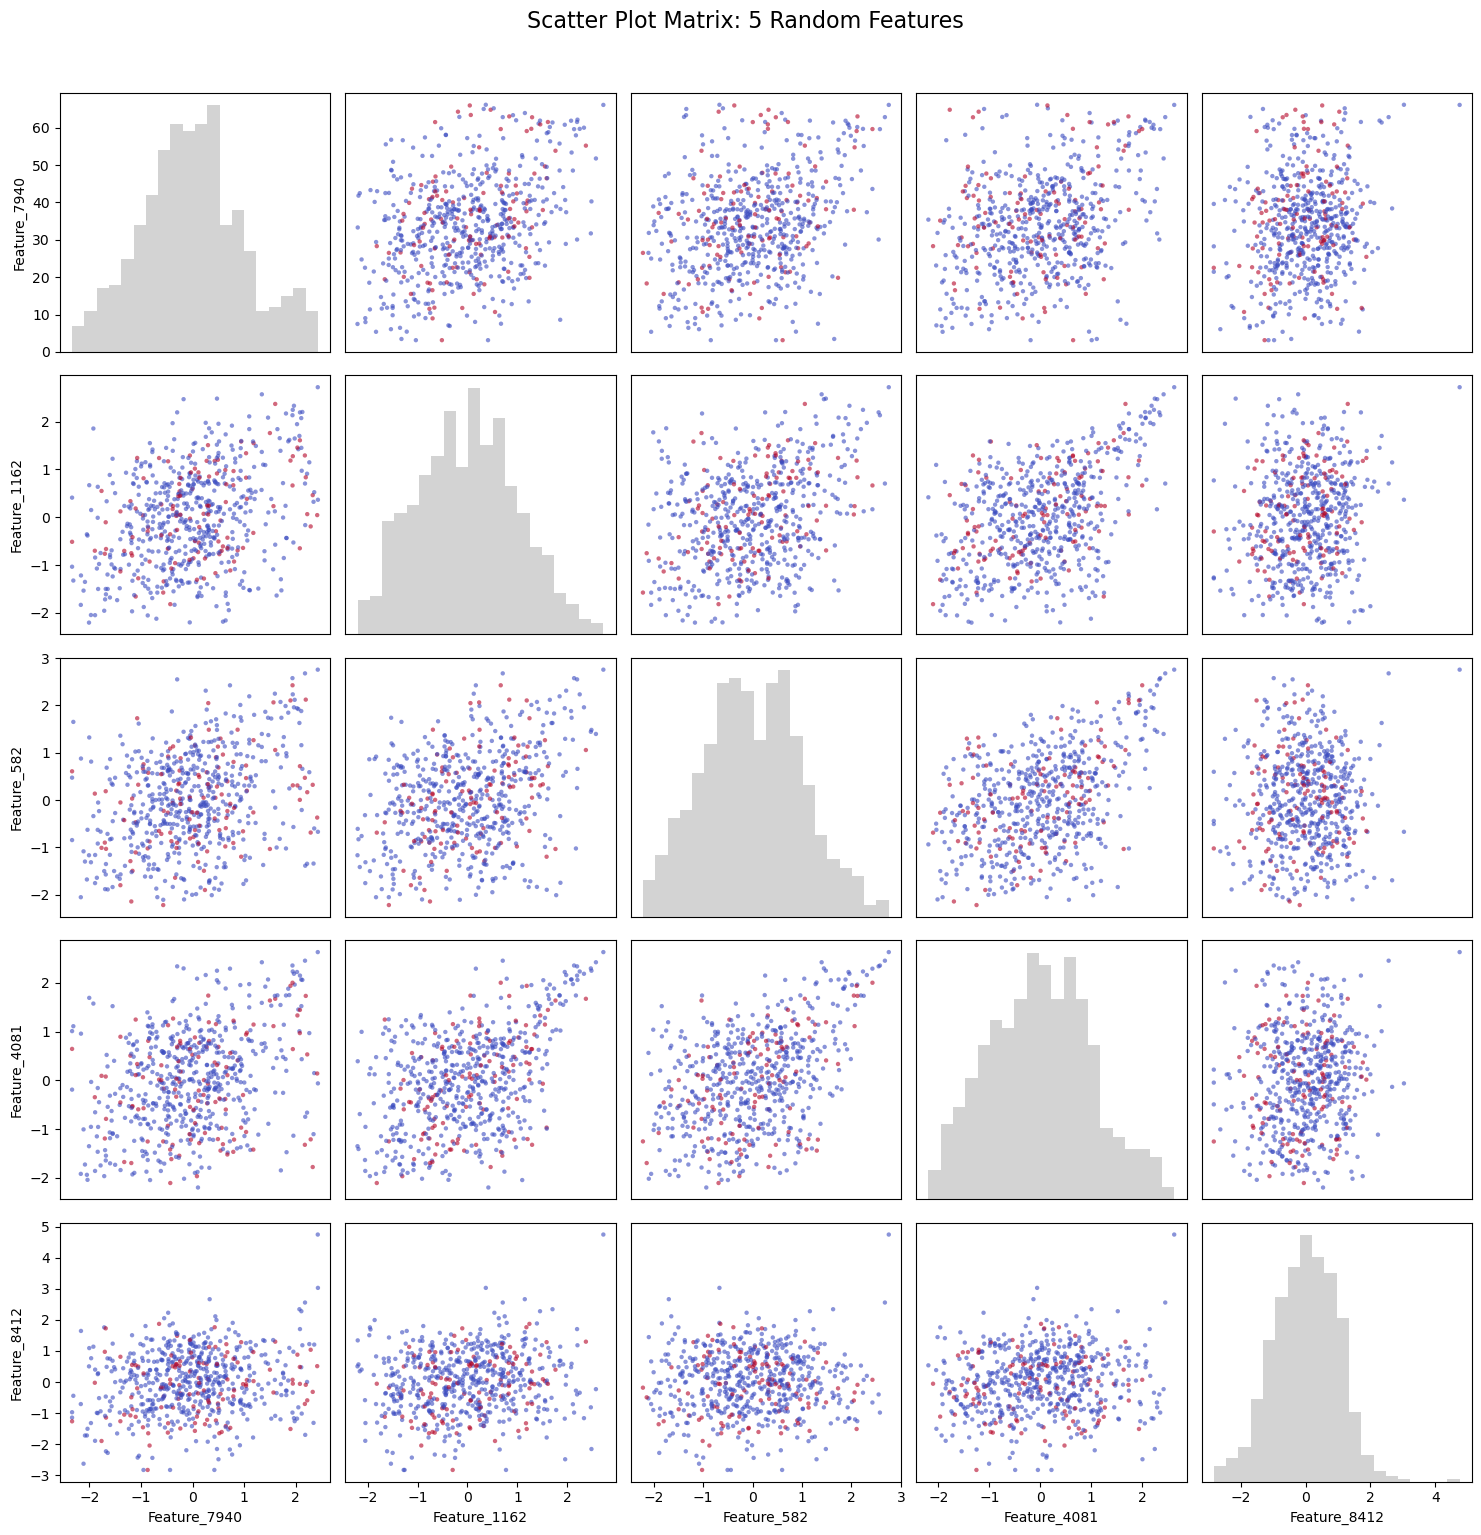

In [15]:
# Pick 5 random features
np.random.seed(42)
random_features = np.random.choice(X_train_transformed.shape[1], size=5, replace=False)

# Subset the data
X_subset = X_train_transformed[:, random_features]
feature_names = [f'Feature_{i}' for i in random_features]

# Create figure
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("Scatter Plot Matrix: 5 Random Features", fontsize=16, y=1.02)

# Fill the grid
for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        if i == j:
            # Plot histogram on the diagonal
            ax.hist(X_subset[:, i], bins=20, color='lightgray')
        else:
            # Scatter plot
            ax.scatter(
                X_subset[:, j], X_subset[:, i],
                c=y_train, cmap='coolwarm', s=10, alpha=0.6, edgecolors='none'
            )
        if i == 4:
            ax.set_xlabel(feature_names[j])
        else:
            ax.set_xticks([])
        if j == 0:
            ax.set_ylabel(feature_names[i])
        else:
            ax.set_yticks([])

plt.tight_layout()
plt.show()

Check features to see what kernel is best

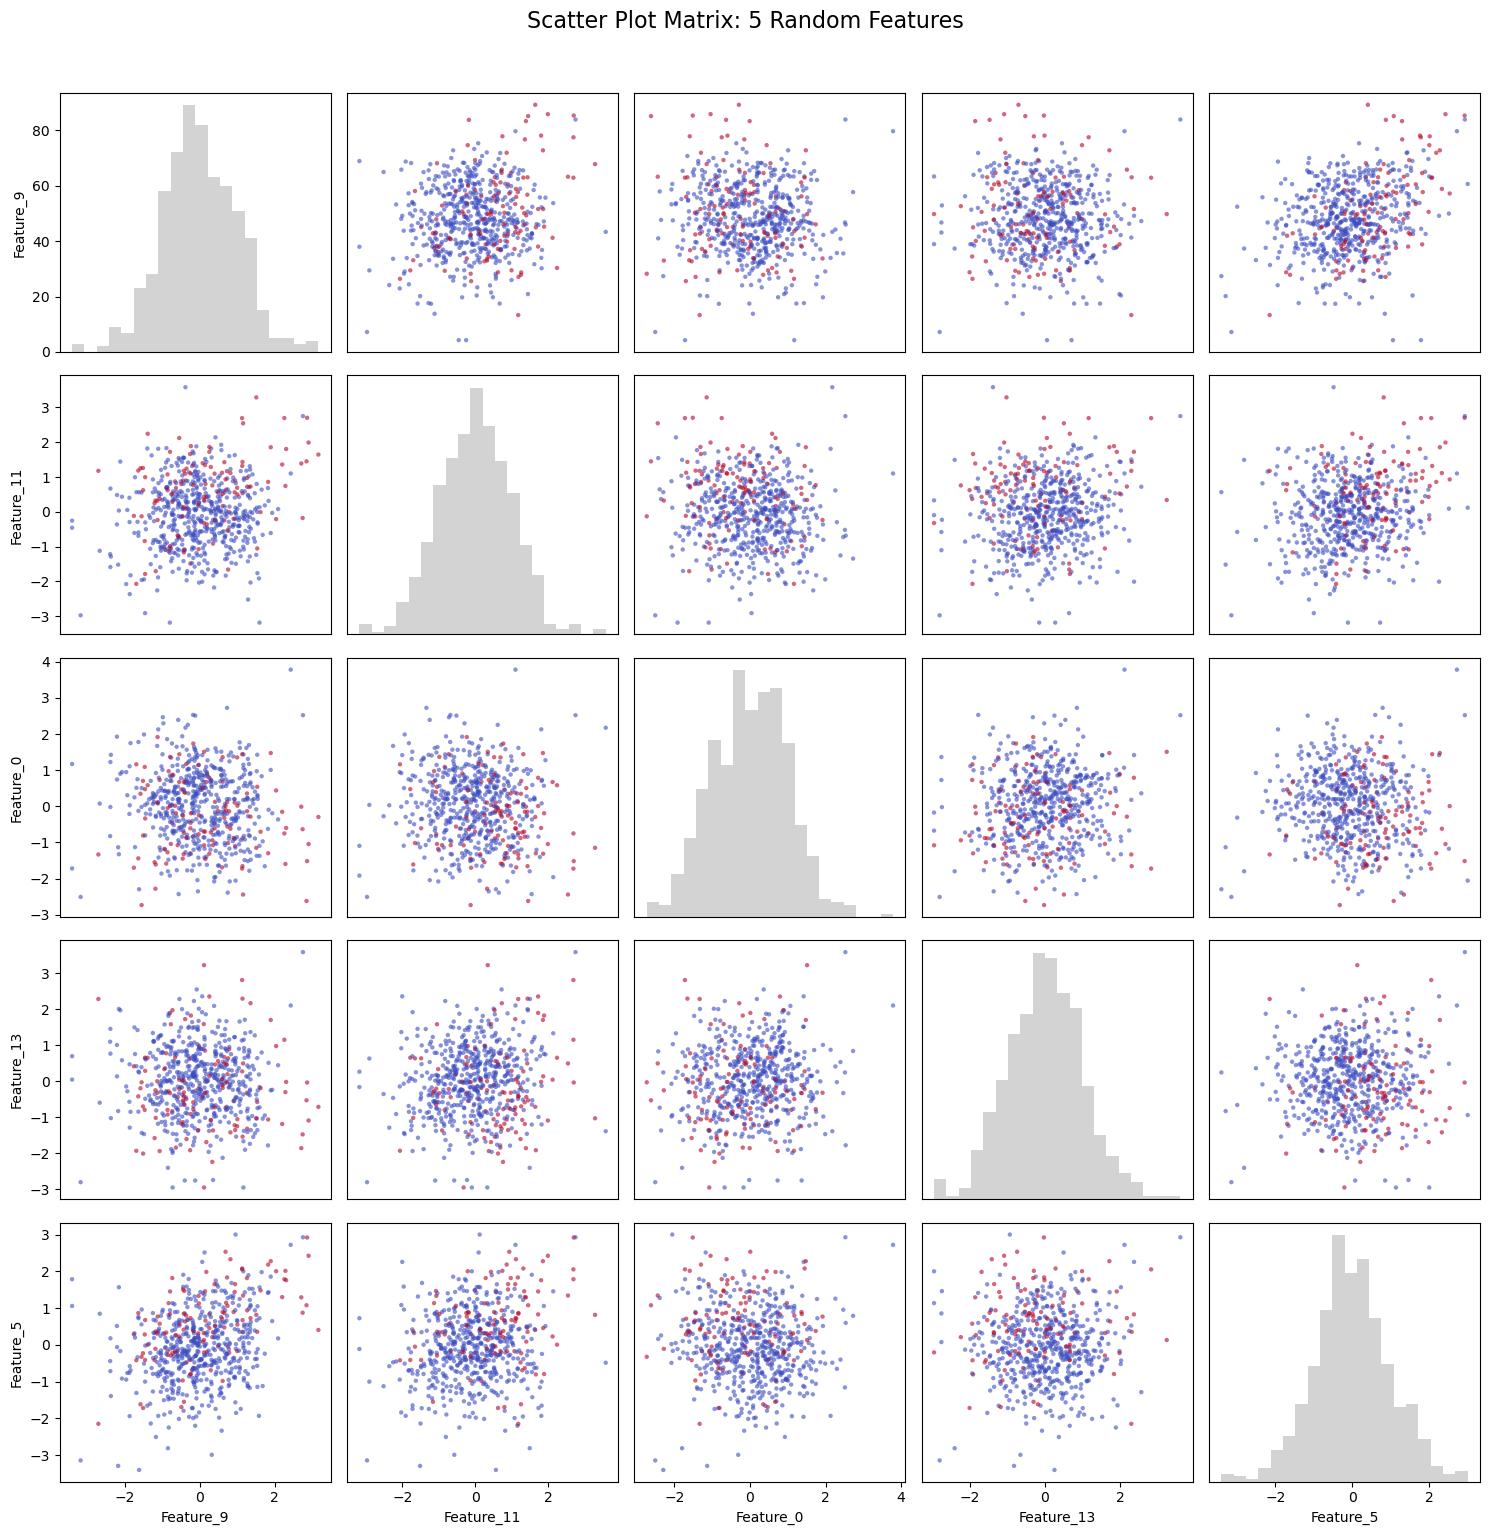

In [11]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)


# Pick 5 random features
np.random.seed(42)
random_features = np.random.choice(X_selected.shape[1], size=5, replace=False)

# Subset the data
X_subset = X_selected[:, random_features]
feature_names = [f'Feature_{i}' for i in random_features]

# Create figure
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("Scatter Plot Matrix: 5 Random Features", fontsize=16, y=1.02)

# Fill the grid
for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        if i == j:
            # Plot histogram on the diagonal
            ax.hist(X_subset[:, i], bins=20, color='lightgray')
        else:
            # Scatter plot
            ax.scatter(
                X_subset[:, j], X_subset[:, i],
                c=y_train, cmap='coolwarm', s=10, alpha=0.6, edgecolors='none'
            )
        if i == 4:
            ax.set_xlabel(feature_names[j])
        else:
            ax.set_xticks([])
        if j == 0:
            ax.set_ylabel(feature_names[i])
        else:
            ax.set_yticks([])

plt.tight_layout()
plt.show()